In [1]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import tensorflow as tf
import cv2

from PIL import Image, ImageOps
import scipy.ndimage as ndi

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img,img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPool2D, Dense
import matplotlib.pyplot as plt

from skimage import transform
import splitfolders
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

In [31]:
# access the google drive 

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# take the image dir and number of image, then plot the image using matplotlib
def plot_imgs(item_dir, num_imgs=25):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(10, 10))
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)
        img = plt.imread(img_path)
        plt.title(f'{img_path}'[-10:-4])
        plt.imshow(img)

    plt.tight_layout()

In [11]:
# set the path for 4 types image folder
path_normal = '/content/drive/MyDrive/kidneyDataSet/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/'
path_stone = '/content/drive/MyDrive/kidneyDataSet/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone/'
path_cyst = '/content/drive/MyDrive/kidneyDataSet/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/'
path_tumor = '/content/drive/MyDrive/kidneyDataSet/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/'

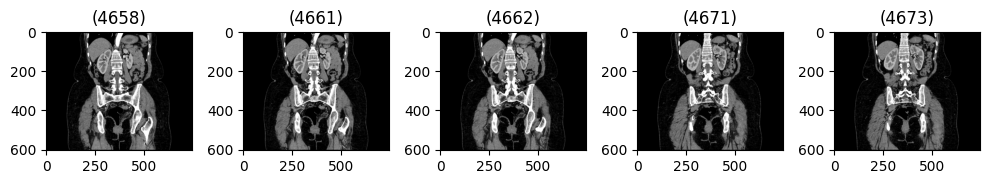

In [6]:
# show the normal images
plot_imgs(path_normal, 5)

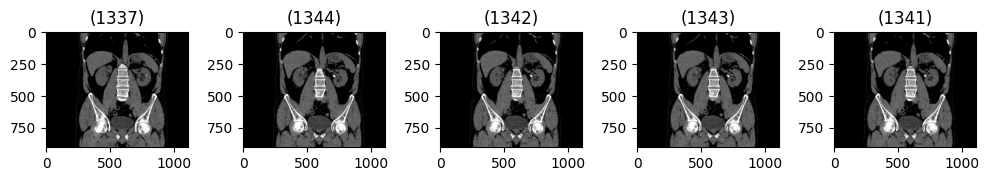

In [12]:
# show the stone images
plot_imgs(path_stone, 5)

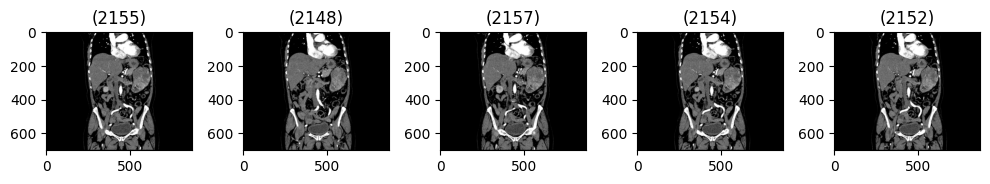

In [13]:
# show the tumor images
plot_imgs(path_tumor, 5)

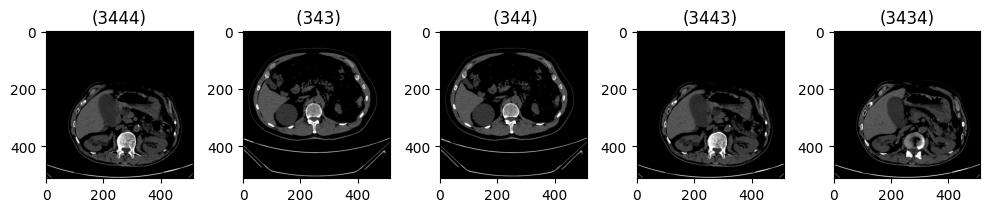

In [14]:
# show the cyst images
plot_imgs(path_cyst, 5)

In [15]:
# split the dataset folder to train/val/test set
splitfolders.ratio(
    "/content/drive/MyDrive/kidneyDataSet/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
   output="./dataset",
   seed=7,
   ratio=(0.8,0.1, 0.1)
)

Copying files: 12473 files [04:24, 47.14 files/s] 


In [16]:
# rescale the images to reduce the more numeric calculation 
# multiply by 1/255 bring the image pixel to 0-1 range
train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)


**flow_from_directory()**
* The directory must be set to the path where your ‘n’ classes of folders are present.   
*   The target_size is the size of your input images, every image will be resized to this size.
* color_mode: if the image is either black and white or grayscale set “grayscale” or if the image has three color channels, set “rgb”.
* batch_size: No. of images to be yielded from the generator per batch.
* class_mode: Set “binary” if you have only two classes to predict, if not set to“categorical”, in case if you’re developing an Autoencoder system, both input and the output would probably be the same image, for this case set to “input”.
* shuffle: Set True if you want to shuffle the order of the image that is being yielded, else set False.
* seed: Random seed for applying random image augmentation and shuffling the order of the image.



In [17]:
train_dataset = train_datagen.flow_from_directory('./dataset/train',
                                                  target_size=(200, 200),
                                                  color_mode='grayscale', 
                                                  class_mode='categorical', 
                                                  batch_size=100,
                                                  )

test_dataset = test_datagen.flow_from_directory('./dataset/test',
                                                target_size=(200, 200),
                                                class_mode='categorical',
                                                color_mode='grayscale',
                                                batch_size=100,
                                                shuffle=False
                                                )

valid_dataset = valid_datagen.flow_from_directory('./dataset/val',
                                                  target_size=(200, 200),
                                                  class_mode='categorical',
                                                  batch_size=100,
                                                  color_mode='grayscale',
                                                  )

Found 9977 images belonging to 4 classes.
Found 1251 images belonging to 4 classes.
Found 1245 images belonging to 4 classes.


In [18]:
# train dataset image size. we provide 200x200 grayscale image so channel is 1
train_dataset.image_shape

(200, 200, 1)

In [21]:
# train dataset class indices
train_dataset.class_indices

{'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}

In [22]:
# create a noise image folder 

import os, skimage
from PIL import Image
from skimage import io

In [23]:
classes = ['Cyst','Normal','Stone','Tumor']

In [32]:
# create salt & paper noise

for class1 in classes:
  images = os.listdir('./dataset/test/{}'.format(class1))
  for idx,img in enumerate(images):
    image = io.imread('./dataset/test/{}/'.format(class1) + img)    
    image = skimage.util.random_noise(image, mode='s&p', seed=None, clip=True,amount=0.1)
    noise_img = np.array(255*image, dtype = 'uint8')
    pil_image=Image.fromarray(np.array(noise_img))
    pil_image.save('/content/drive/MyDrive/kidneyDataSet/salt_paper_noise_1/{}/test-{}.jpg'.format(class1,idx))

In [27]:
# create gaussian noise

for class1 in classes:
  images = os.listdir('./dataset/test/{}'.format(class1))
  for idx,img in enumerate(images):
    image = io.imread('./dataset/test/{}/'.format(class1) + img)    
    image = skimage.util.random_noise(image, mode='gaussian', seed=None, clip=True,var=0.1)
    noise_img = np.array(255*image, dtype = 'uint8')
    pil_image=Image.fromarray(np.array(noise_img))
    pil_image.save('/content/drive/MyDrive/kidneyDataSet/gaussian_noise_1/{}/test-{}.jpg'.format(class1,idx))

In [25]:
# create speckle noise 

for class1 in classes:
  images = os.listdir('./dataset/test/{}'.format(class1))
  for idx,img in enumerate(images):
    image = io.imread('./dataset/test/{}/'.format(class1) + img)    
    image = skimage.util.random_noise(image, mode='speckle', seed=None, clip=True,var=0.1)
    noise_img = np.array(255*image, dtype = 'uint8')
    pil_image=Image.fromarray(np.array(noise_img))
    pil_image.save('/content/drive/MyDrive/kidneyDataSet/speckle_noise_1/{}/test-{}.jpg'.format(class1,idx))